In [1]:
import datetime
import pathlib
import time
import math

import obspy
from obspy.signal import PPSD
import scipy

#%matplotlib #Run this line if you want interactive plots
import matplotlib.pyplot as plt
import numpy as np

import hvsr

In [2]:
dPath = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\LakeCalumet\LC_RaspShake'
mPath = 'resources\raspshake_metadata.inv'

params = hvsr.input_param(network='AM',
                            station='RAC84',
                            loc='00', 
                            channels=['EHZ', 'EHN', 'EHE'],
                            acq_date = 46, #'2023-02-15'
                            starttime = '11:00:00.00',
                            endtime = '11:34:00.00',
                            tzone = -6,#or 'local', #or 'UTC'
                            dst=False,
                            lon = -88.2290526,
                            lat =  40.1012122,
                            elevation = 755,
                            site='Test',
                            depth = 0,
                            instrument='Raspberry Shake',
                            dataPath = dPath,
                            metaPath = mPath
                            )

ERROR: Metadata file does not exist!
Using default metadata file for Raspberry Shake v.7 contained in repository at
 c:/Users/riley/LocalData/Github/hvsrpy/resources/raspshake_metadata.inv


In [3]:
params = hvsr.get_metadata(params)
inStream = hvsr.fetch_data(params)
stream = hvsr.trim_data(inStream, params, export_format='mseed', export_dir=params['dataPath'])
ppsds = hvsr.generate_ppsds(params=params, stream=stream, ppsd_length=60)

Day of Year: 46


c:\Users\riley\.conda\envs\seismic38\lib\site-packages\obspy\core\inventory\network.py:249: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)


In [6]:
hvsr_dict = hvsr.process_hvsr(params=params, method=4, resample=False, smooth=5)
hvsr_dict = hvsr.check_peaks(hvsr_dict=hvsr_dict, rank=True, hvsr_band=[0.5, 25], peak_water_level=1.8, do_rank=False)

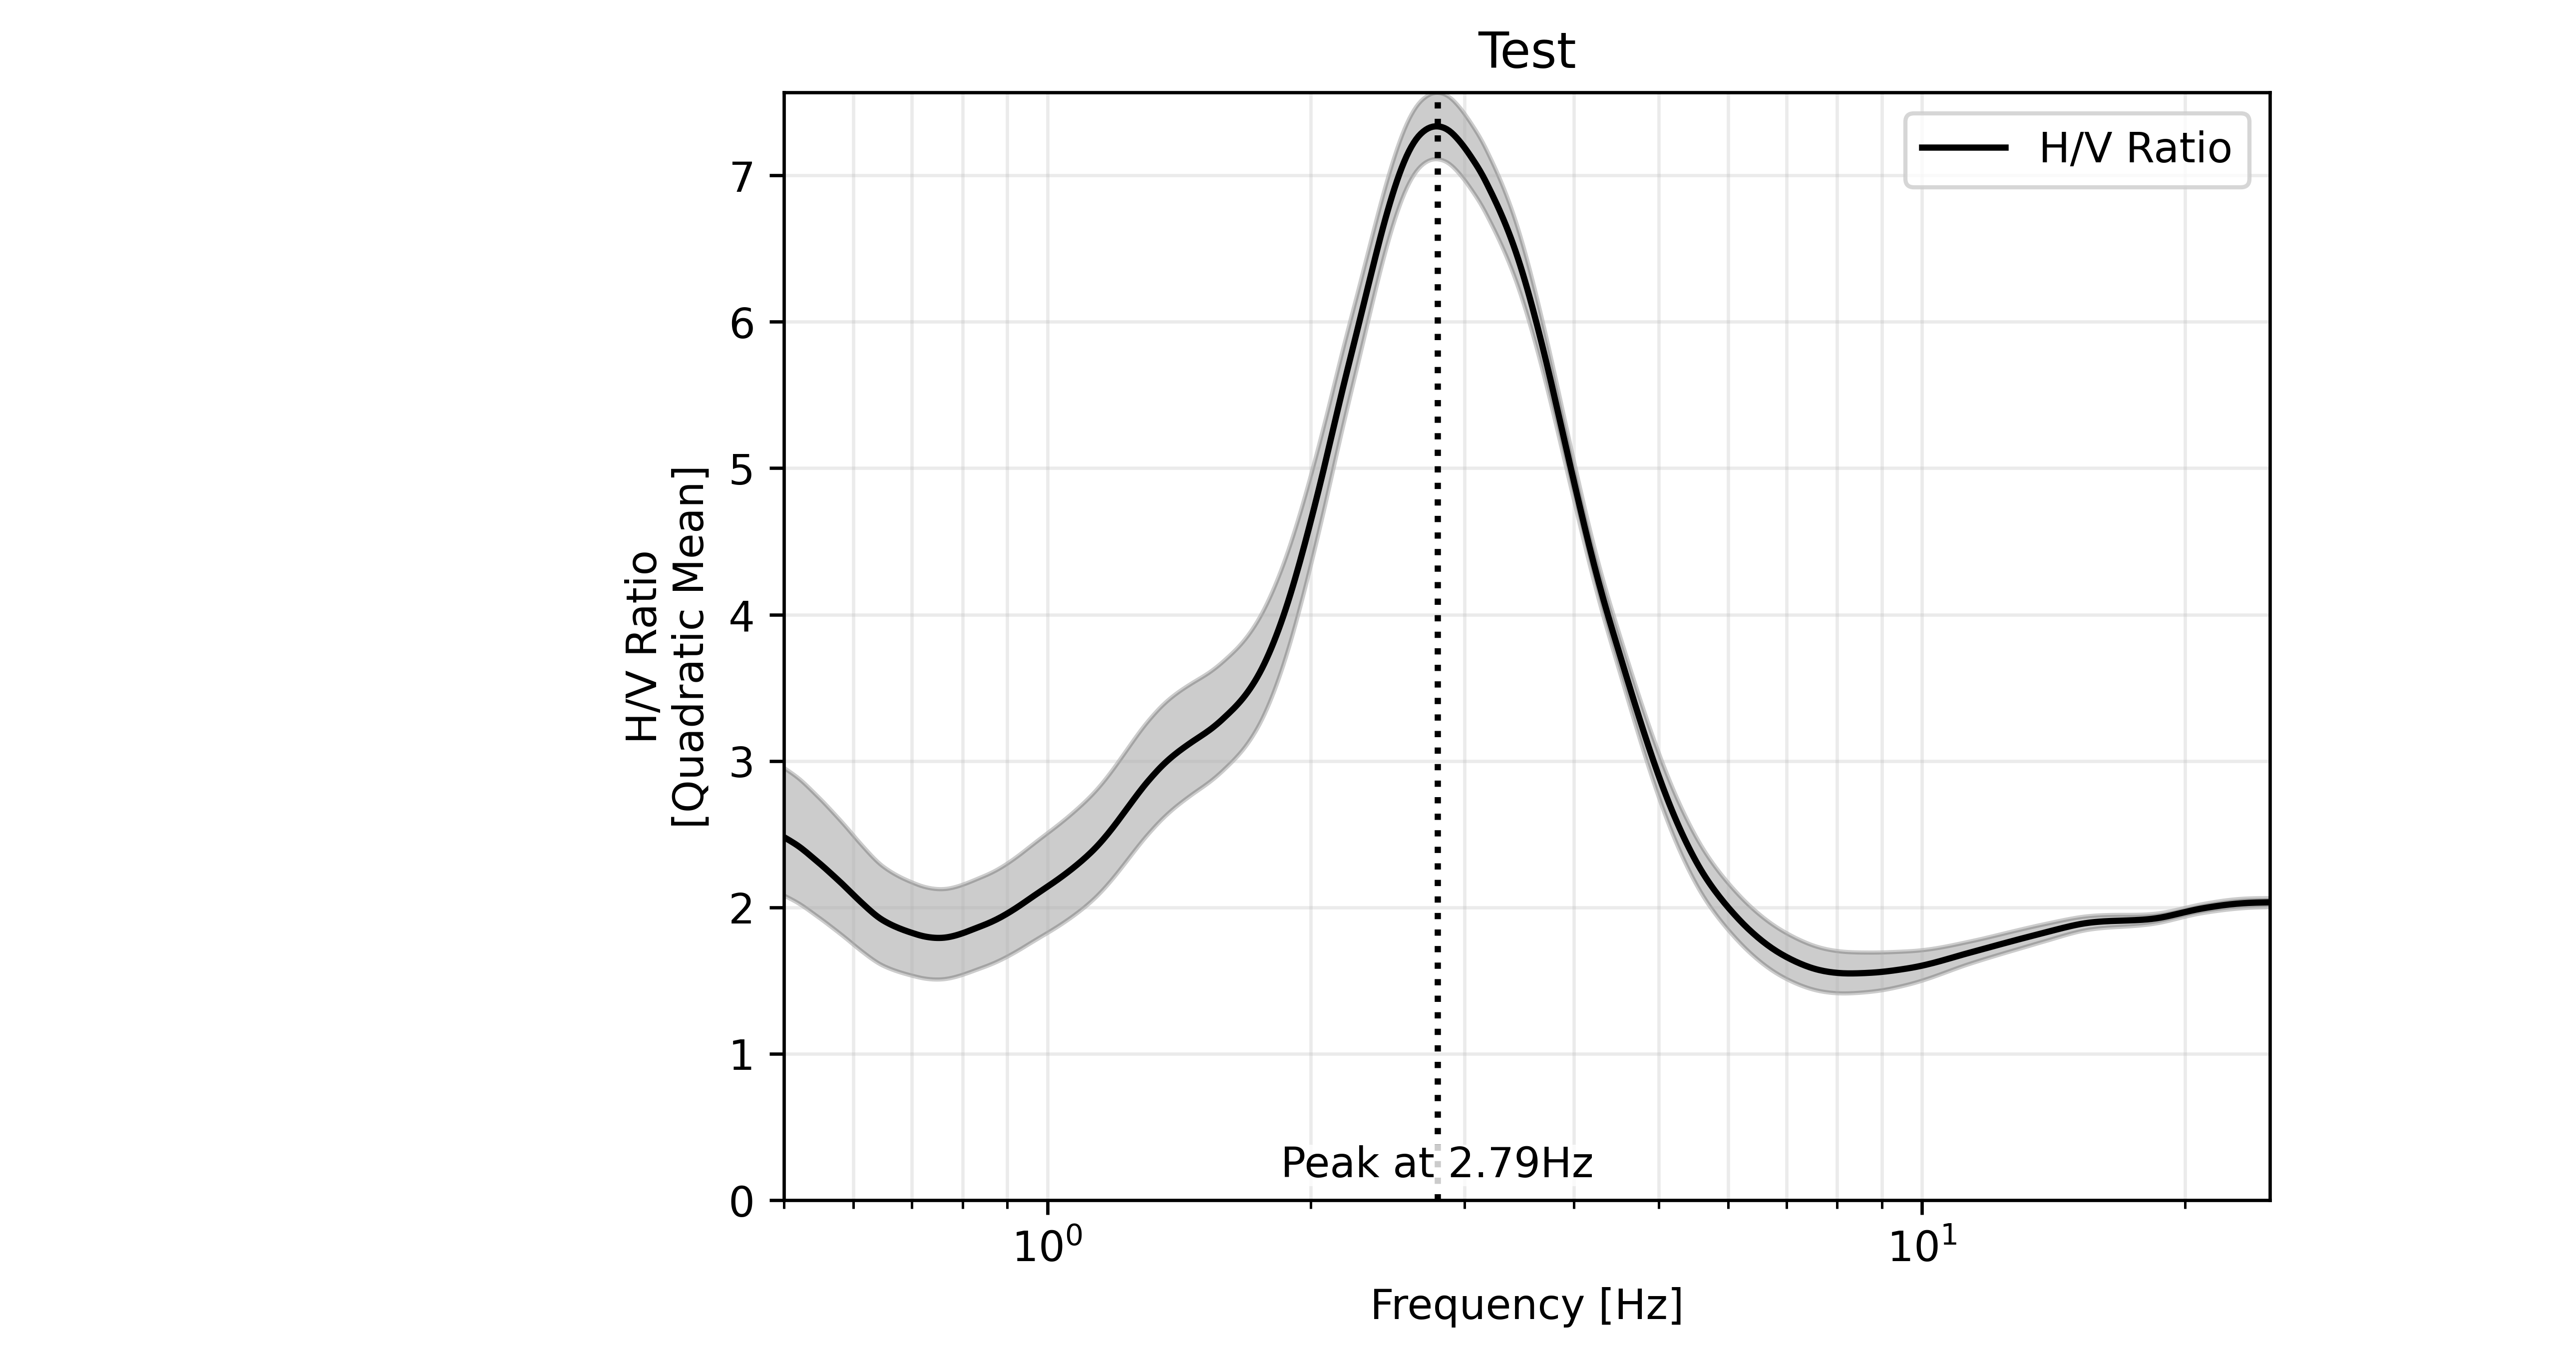

In [7]:
hvsr.hvplot(hvsr_dict, kind='HVSR p all ann', grid='both', save_dir=r'C:\Users\riley\OneDrive\Desktop', show=True)

In [15]:
hvsr_dict['Peak Report']

[{'f0': 16.350281587308455,
  'A0': 1.9178727287765707,
  'f-': 'X',
  'f+': 'X',
  'Sf': 4.059649752910257,
  'Sa': 0.027167910711454368,
  'Score': 2,
  'Report': {'A0': '      1.92 > 2.0 X',
   'P+': '16.248 within ±5% of 16.350 ✔',
   'P-': '16.350 within ±5% of 16.350 ✔',
   'Sf': '    4.0596 < 0.05 * 16.350  X',
   'Sa': '    0.0272 < 0.20 ✔'},
  'Pass List': {'Window Length Freq.': True,
   'Significant Cycles': True,
   'Low Curve StDev. over time': True,
   'Peak Freq. Clarity Below': False,
   'Peak Freq. Clarity Above': False,
   'Peak Amp. Clarity': False,
   'Freq. Stability': True,
   'Peak Stability (freq. std)': False,
   'Peak Stability (amp. std)': True}},
 {'f0': 2.6566753805589776,
  'A0': 7.3307984743448795,
  'f-': '     0.668 ✔',
  'f+': '    10.627 ✔',
  'Sf': 3.9771819692175865,
  'Sa': 0.027090360316231913,
  'Score': 5,
  'Report': {'A0': '      7.33 > 2.0 ✔',
   'P+': '2.657 within ±5% of 2.657 ✔',
   'P-': '2.657 within ±5% of 2.657 ✔',
   'Sf': '    3.9772

In [16]:
for i in hvsr_dict['Peak Report']:
    print(i['f0'], i['Score'])


16.350281587308455 2
2.6566753805589776 5
0.5438699674087909 2
0.5238695864998677 2
0.5173675933964794 3
